# Sentiment Analysis through My WhatsApp Messages

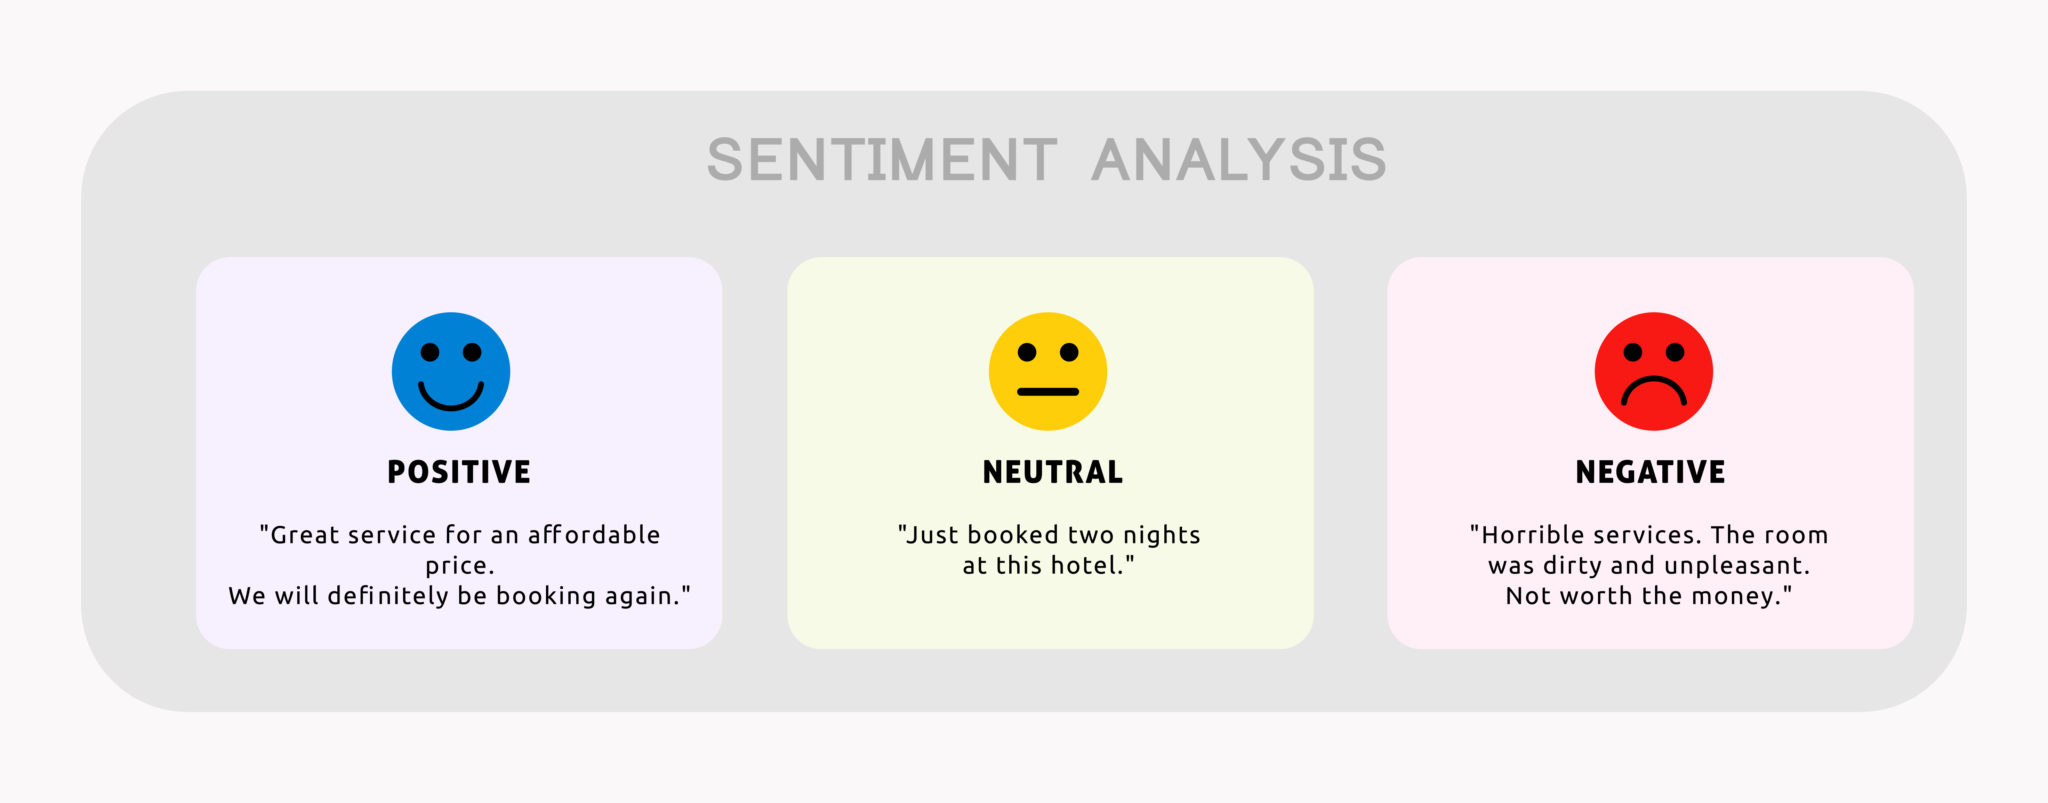


# Sentiment Analysis

## 1. Data Collection
- Collecting conversational data from WhatsApps, ensuring the inclusion of timestamps for each interaction.


## 2. Data Cleaning

- Handle missing values
- Convert to lowercase
- Remove special characters
- Remove links
- Tokenization
- Remove stopwords
- Spell checking

# Habit Analysis

After the data collection, the intensity of the conversation will be observed according to time and date
- Get the intensity of messages
- Observe them by the periods of day
- Combine this knowledge with the sentiment score of the messages
 

## Data Collection

### Importing the necessary libraries

In [31]:
import pandas as pd
import re
from datetime import datetime
from datetime import datetime, timedelta, date, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Set the environment for Sentiment Analysis using BERT-based Turkish Mode
- Load the pre-trained BERT-based model and tokenizer for sentiment analysis


In [32]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

### Set the environment for Spell Checking using ZEMBEREK Turkish NLP

- This section demonstrates spell checking functionality using the ZEMBEREK Turkish NLP library. The code utilizes various modules from the library, including TurkishSpellChecker, TurkishSentenceNormalizer, TurkishSentenceExtractor, TurkishMorphology, and TurkishTokenizer.

In [33]:
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)

In [34]:
# create the enviroment for Zemberek Model
morphology = TurkishMorphology.create_with_defaults()
normalizer = TurkishSentenceNormalizer(morphology)
spell_checker = TurkishSpellChecker(morphology)

2024-01-14 17:15:34,813 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 18.781240940093994



### Some pre-cleaning is done while generating the dataset 
- Handle missing values
- Convert to lowercase
- Remove special characters
- Remove links
- Remove stop words

In [35]:
custom_stopwords_file = 'TurkishStopWords.txt'

with open(custom_stopwords_file, 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file]

In [36]:
def genDataset(messages):
    dataset = []
    last_received_message = None

    for message in messages:
        # Extract date and time using regular expressions
        match_datetime = re.search(r'\[(\d+\.\d+\.\d+), (\d+:\d+:\d+)\]', message)
        if match_datetime:
            date_str, time_str = match_datetime.groups()
            message_date = datetime.strptime(f"{date_str} {time_str}", "%d.%m.%Y %H:%M:%S")
            date_only = message_date.date()
            time_only = message_date.time()
        else:
            date_only, time_only = None, None  # Handle the case where date and time are not found

        # Extract sender and content using a more specific pattern
        sender_match = re.search(r'(\w+\s\w+): (.+)', message)
        if sender_match:
            sender, content = sender_match.groups()
        else:
            sender, content = None, None  # Handle the case where sender and content are not found

        if content is not None and  date_only is not None and time_only is not None:
            # Remove special characters, pre-cleaning
            content = re.sub(r'[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]', '', content)
    
            # pre-cleaning
            if (
                content.startswith("https") or
                "omitted" in content or
                content == "." or
                "Missed voice call" in content
            ):
                content = None

            if content is not None:
                # Remove stopwords
                content_tokens = content.split()
                content_tokens = [token for token in content_tokens if token.lower() not in stopwords]
                content = ' '.join(content_tokens)
                
            # Create the dataset
            if content is not None and content != "":
                # pre-cleaning
                content = content.lower()
                              
                # If the time gap is smaller than 1 minute for the same sender, combine the message
                if (
                    last_received_message is not None
                    and (datetime.combine(date.today(), time_only) - datetime.combine(date.today(), last_received_message['time'])) < timedelta(minutes=1)
                    and sender == last_received_message['sender']
                ):
                    last_received_message['text'] += " " + f"{content}"
                else:
                    received_message = {
                        'date': date_only,
                        'time': time_only,
                        'sender': sender,
                        'text': content
                    }
                    dataset.append(received_message)
                    last_received_message = received_message  # Update the last received message

    return dataset

In [37]:
person = 'Person 1.txt'

# read last n lines
with open(person, 'r', encoding='utf-8') as file:
    last_lines = file.readlines()[-3000:]

dataset = genDataset(last_lines)
# Create a DataFrame from the list of messages
df = pd.DataFrame(dataset)

## Post Data Cleaning

### 1. Handle Missing Values

Address any missing or null values in the text data.

In [38]:
#check if there is null values
df.isnull().sum()

date      0
time      0
sender    0
text      0
dtype: int64

### 2. Replace certain acronyms with comprehensible terms

We must make informal communications more formal in order to better comprehend the message's sentiment.

In [39]:
# Formalization function
def formalize(word):
    replacements = {
        "np": "sorun değil",
        "oki": "tamam",
        "oli": "oki",
        "ok": "tamam",
        "hee": "anladım",
        "he": "anladım",
        "cmt": "cumartesi",
        "nice": "iyi",
        "niye": "neden",
        "yeto": "gına geldi",
        "bi dakka": "bir dakika",
        "zort": "tüh",
        "yep": "evet",
        "bi": "bir",
        "knk": "kanka"
    }
    return replacements.get(word, word)

In [40]:
df['formalized_text'] = df['text'].apply(lambda sentence: ' '.join([formalize(word) for word in sentence.split()]))

### 3. Spell Checking using ZEMBEREK NLP

Corrects typos and misspelled words.

In [41]:
# Apply the ZEMBEREK Module normalization to the entire 'formalized_text' column
df['formalized_text'] = df['formalized_text'].apply(lambda x: normalizer.normalize(x))

### 4. Applying Sentiment Anaylsis Using Bert Based Turkish Module

In [42]:
df['sentiment'] = df['formalized_text'].apply(sa)

In [43]:
# Function to extract sentiment score and handle sign based on label
def update_sentiment(sentiment_result):
    if sentiment_result:
        label = sentiment_result[0]['label']
        score = sentiment_result[0]['score']
        if label == 'positive':
            return score
        elif label == 'negative':
            return -score
        else:
            return 0
    else:
        return None

# Apply the function to the 'sentiment' column
df['sentiment'] = df['sentiment'].apply(update_sentiment)

## Message Intensity Analysis

For the intensity analysis the count of every messages will be hold as another attribute

In [44]:
# Add a new column 'intensity' to store word count
df['intensity'] = df['text'].apply(lambda x: len(str(x).split()))

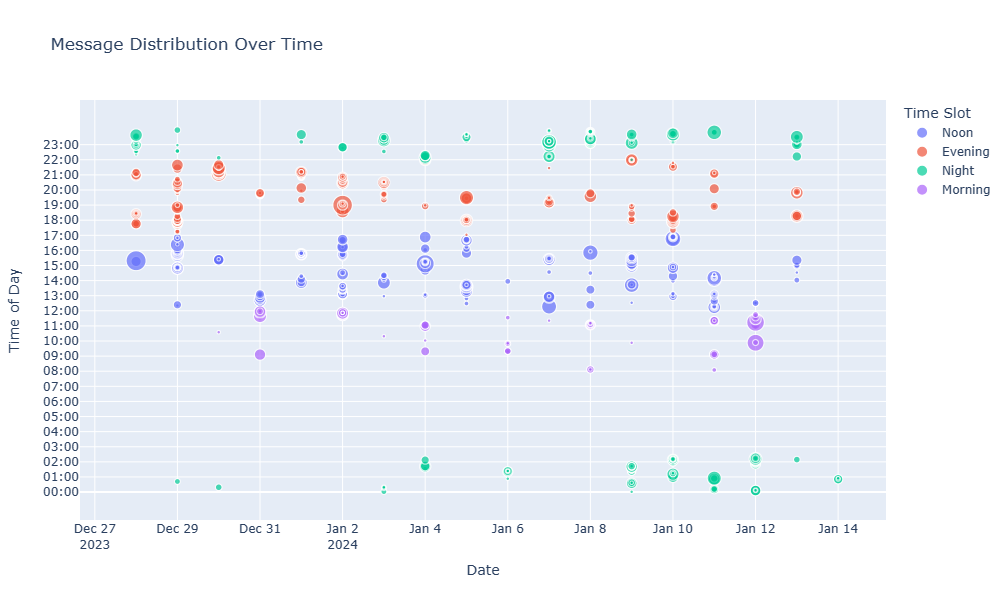

In [45]:
import plotly.express as px

# Function to categorize time into slots
def categorize_time(hour):
    if 7 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

# Apply the categorize_time function to create a new column 'time_slot'
df['hour'] = df['time'].astype(str).str.split(":").str[0].astype(int)
df['minute'] = df['time'].astype(str).str.split(":").str[1].astype(int)
df['time_slot'] = df.apply(lambda row: categorize_time(row['hour']), axis=1)

# Create a scatter plot
fig = px.scatter(df, x='date', y=df['hour'] + df['minute'] / 60, color='time_slot',
                 labels={'y': 'Time of Day', 'date': 'Date', 'time_slot': 'Time Slot'},
                 title='Message Distribution Over Time',
                 size='intensity', hover_data=['intensity', 'time'],
                 category_orders={'hour': [str(i) for i in range(24)]})

# Set y-axis tick values to fixed hours
fig.update_yaxes(tickvals=list(range(24)), ticktext=[str(i).zfill(2) + ':00' for i in range(24)])

# Update layout to make it more readable
fig.update_layout(
    height=600,
    width=1000
)

# Exclude the y-axis column from hover data
fig.update_traces(
    hovertemplate='Date: %{x}<br>Intensity: %{customdata[0]}<br>Time: %{customdata[1]}'
)

fig.show()

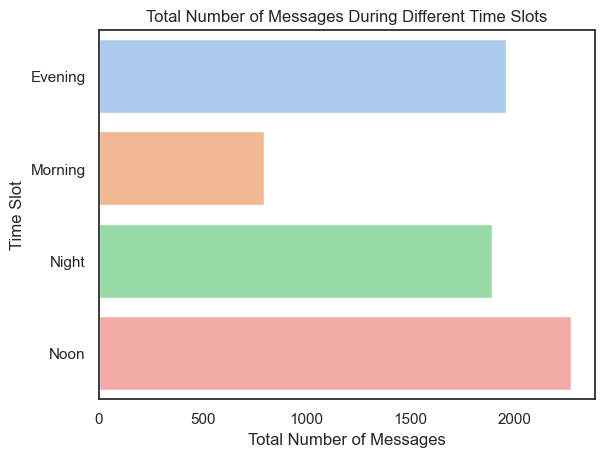

<Figure size 800x400 with 0 Axes>

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

total_messages = df.groupby('time_slot')['intensity'].sum().reset_index()
sns.set_palette("pastel")

# Plot the total number of messages for each time slot with different colors
sns.barplot(y='time_slot', x='intensity', data=total_messages, palette='pastel',legend = False)
plt.title('Total Number of Messages During Different Time Slots')
plt.xlabel('Total Number of Messages')
plt.ylabel('Time Slot')
plt.figure(figsize=(8, 4))
plt.show()

In [47]:
# drop the features that no longer to be used
df.drop([ 'hour', 'minute'], axis=1, inplace=True)

# Sentiment Scores Table
- In this analysis, a table containing sentiment scores for every message is presented. The sentiment scores were calculated using the BERT-Turkish model. This table serves as the foundation for hypothesis testing to explore patterns and trends in sentiment across different time slots.

## Sentiment Scores Overview 
- The table below provides a comprehensive view of sentiment scores for each message. These scores include both positive and negative values, allowing for a detailed examination of the sentiment distribution.

In [48]:
# The weighted sentiment score is calculated by considering the intensity of each message
# If the count of a message is higher (higher intensity), its sentiment score is more influential

# Calculate the total intensity in the DataFrame
total_intensity = df['intensity'].sum()

# Create a new column for weighted sentiment scores
df['weighted_sentiment'] = (df['intensity'] / total_intensity) * df['sentiment']

# Calculate the maximum and minimum values of the weighted sentiment column
max_weighted_sentiment = df['weighted_sentiment'].max()
min_weighted_sentiment = df['weighted_sentiment'].min()

# Scale the values to the range of -1 to 1
df['weighted_sentiment'] = 2 * ((df['weighted_sentiment'] - min_weighted_sentiment) / (max_weighted_sentiment - min_weighted_sentiment)) - 1

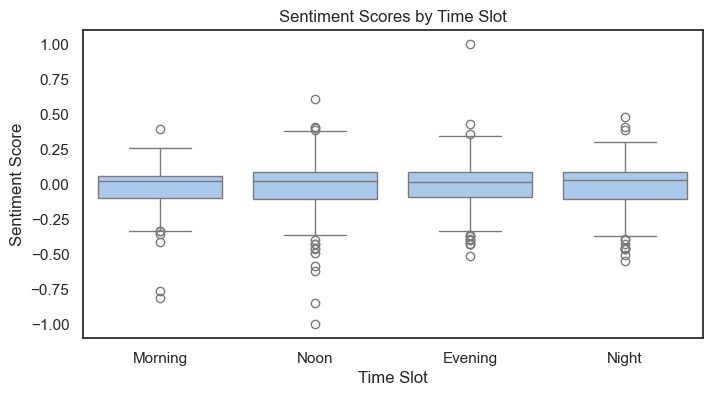

In [49]:
df['weighted_sentiment'] = pd.to_numeric(df['weighted_sentiment'])
df['time_slot'] = pd.Categorical(df['time_slot'], categories=['Morning', 'Noon','Evening', 'Night'], ordered=True)

# Visualize sentiment scores by time slot
plt.figure(figsize=(8, 4))
sns.boxplot(x='time_slot', y='weighted_sentiment', data=df)
plt.title('Sentiment Scores by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Sentiment Score')
plt.show()

## Positive Sentiment Scores 
- The table below provides a comprehensive view of positive sentiment scores for each messages

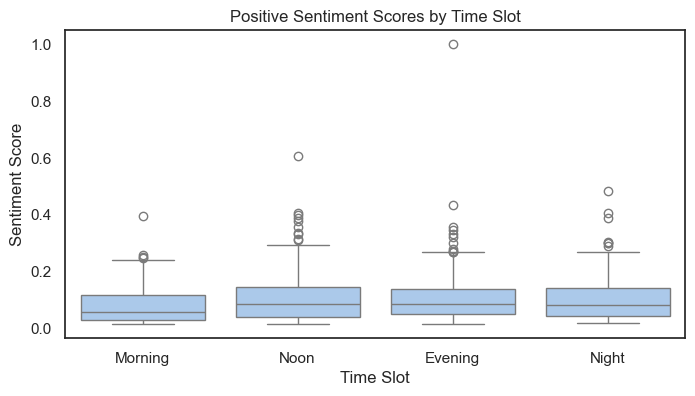

In [50]:
# Filter DataFrame for positive sentiment scores
positive_df = df[df['weighted_sentiment'] > 0]

# Visualize positive sentiment scores by time slot
plt.figure(figsize=(8, 4))
sns.boxplot(x='time_slot', y='weighted_sentiment', data=positive_df)
plt.title('Positive Sentiment Scores by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Sentiment Score')
plt.show()

### Negative Sentiment Scores 
- Next, I explore the distribution of negative sentiment scores over time slots.

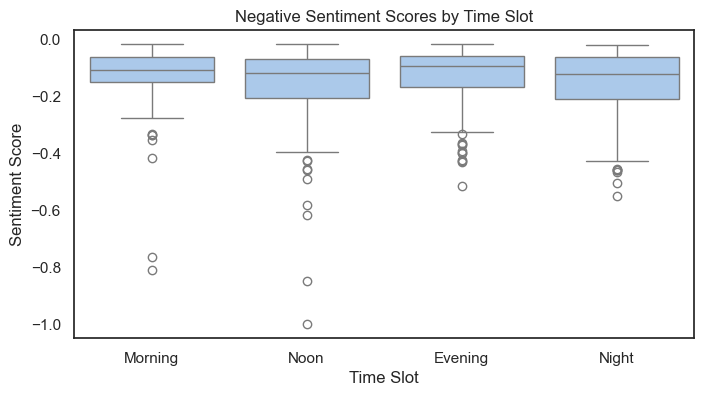

In [51]:
# Filter DataFrame for negative sentiment scores
negative_df = df[df['weighted_sentiment'] < 0]

# Visualize negative sentiment scores by time slot
plt.figure(figsize=(8, 4))
sns.boxplot(x='time_slot', y='weighted_sentiment', data=negative_df)
plt.title('Negative Sentiment Scores by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Sentiment Score')
plt.show()

# Hypothesis Testing

### Null Hypothesis(H0)
- There is no significant correlation between the selected periods of the day.

### Alternative Hypothesis(H1)
- There is a significant correlation between the selected periods of the day.

### Hypothesis Testing Technique: 
- In this section, I employ the Pearson correlation test to assess the correlation between different variables.
- The `pearsonr` function is utilized to calculate both correlation coefficients and associated p-values for hypothesis testing.

### Purpose: 
- The Pearson correlation test is employed to understand the strength and direction of the linear relationship between two variables. This analysis provides insight into whether changes in one variable are associated with systematic changes in another.

### Method: 

- The code snippet utilizes the pearsonr function from the scipy.stats library to conduct hypothesis testing based on the Pearson correlation coefficient. This coefficient is employed to measure the linear relationship between two variables, providing insights into the strength and direction of their association. The accompanying p-value assists in evaluating the statistical significance of the observed correlation. 

- In this context, the null hypothesis posits that there is no correlation between the specified pairs of variables. The code then calculates the p-value associated with the correlation coefficients for morning vs. night average sentiment and evening vs. noon average sentiment. The significance level (alpha) is set to 0.05, a commonly used threshold in hypothesis testing. 

- The subsequent evaluation of results involves comparing the computed p-values with the chosen significance level. If a p-value is less than the significance level, it suggests that there is a statistically significant correlation between the respective pairs of variables. Conversely, if the p-value exceeds the significance level, the conclusion is that there is no significant correlation.

### Analysis of Weighted Sentiment Over Time to Derive a Correlation Heapmap
- In this analysis, I examine the trends in weighted sentiment over time by grouping the data based on date and time slots. The weighted sentiment is calculated and averaged for each group, resulting in a pivot table that provides insights into sentiment patterns during different times of the day.

In [52]:
# Convert the 'date' column to datetime type if it's not already
df['date'] = pd.to_datetime(df['date'])

# Group by date and time_slot, then calculate the average sentiment for each group
grouped_df = df.groupby(['date', 'time_slot'])['weighted_sentiment'].mean().reset_index()

# Pivot the table to create a new DataFrame with columns: date, morning, night, evening, noon
pivot_df = grouped_df.pivot(index='date', columns='time_slot', values='weighted_sentiment').reset_index()

# Rename columns
pivot_df.columns = ['date', 'morning_avg_sentiment', 'night_avg_sentiment', 'evening_avg_sentiment', 'noon_avg_sentiment']

# Fill NaN values with the average value of each column
pivot_df = pivot_df.apply(lambda col: col.fillna(col.mean()))

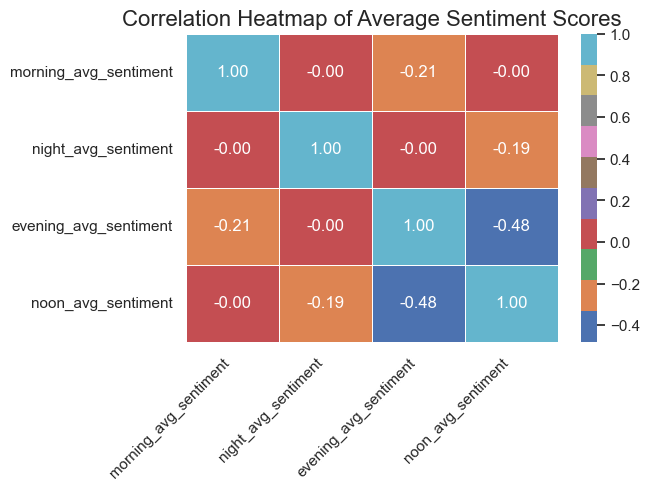

In [53]:
correlation_matrix = pivot_df[['morning_avg_sentiment', 'night_avg_sentiment', 'evening_avg_sentiment', 'noon_avg_sentiment']].corr()

# Set the style of the visualization
sns.set(style="white")
plt.figure(figsize=(6, 4))
palette = sns.color_palette("deep")
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap=palette, fmt=".2f", linewidths=.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.title('Correlation Heatmap of Average Sentiment Scores', fontsize=16)

plt.show()

### Correlation Analysis of Sentiment During Different Time Slots

In this section, I test the correlations between sentiment scores during various time slots, using the Pearson correlation test.

In [54]:
from itertools import combinations
from scipy.stats import pearsonr

# Select the significance level
alpha = 0.05

# Get all combinations of periods
periods = ['morning_avg_sentiment', 'night_avg_sentiment', 'evening_avg_sentiment', 'noon_avg_sentiment']
combinations_of_periods = list(combinations(periods, 2))

# Perform hypothesis tests for each pair
for pair in combinations_of_periods:
    period1, period2 = pair
    correlation_coefficient = correlation_matrix.loc[period1, period2]
    
    # Perform hypothesis test
    p_value = pearsonr(pivot_df[period1], pivot_df[period2])[1]

    # Evaluate results
    if p_value < alpha:
        print(f"There is a significant correlation between {period1} and {period2}.")
    else:
        print(f"There is no significant correlation between {period1} and {period2}.")


There is no significant correlation between morning_avg_sentiment and night_avg_sentiment.
There is no significant correlation between morning_avg_sentiment and evening_avg_sentiment.
There is no significant correlation between morning_avg_sentiment and noon_avg_sentiment.
There is no significant correlation between night_avg_sentiment and evening_avg_sentiment.
There is no significant correlation between night_avg_sentiment and noon_avg_sentiment.
There is a significant correlation between evening_avg_sentiment and noon_avg_sentiment.


## Sentiment Correlations Findings: 
1. **Morning vs. Night Sentiment:**

   - There is **no significant** correlation between morning_avg_sentiment and night_avg_sentiment.

3. **Morning vs. Evening Sentiment:**

   - There is **no significant** correlation between morning_avg_sentiment and evening_avg_sentiment.

5. **Morning vs. Noon Sentiment:**
    
    - There is **no significant** correlation between morning_avg_sentiment and noon_avg_sentiment.

6. **Night vs. Evening Sentiment:**
    
    - There is **no significant** correlation between night_avg_sentiment and evening_avg_sentiment.

7. **Night vs. Noon Sentiment:**
    
    - There is **no significant** correlation between night_avg_sentiment and noon_avg_sentiment.

8. **Evening vs. Noon Sentiment:**
    
    - There is a **significant** correlation between evening_avg_sentiment and noon_avg_sentiment.

## Interpretation: 
The lack of significant correlations in most comparisons suggests that the sentiment during one time slot is generally independent of the sentiment during other time slots. This indicates that factors influencing sentiment may vary throughout the day. However, the significant correlation between evening and noon sentiment implies a potential pattern or similarity in sentiment during these specific time slots. Further investigation into the nature of this correlation may provide valuable insights into factors influencing sentiment during these times. This analysis lays the groundwork for understanding the temporal dynamics of sentiment and can guide future explorations or targeted interventions during specific time slots.

## Habit Analysis Findings:

The total number of messages during different time slots follows the following ranks:

1. **Noon:**
   - Noon has the highest total number of messages, indicating that this time slot is the most active in terms of messaging intensity.

2. **Evening:**
   - The evening comes next in terms of total messages, suggesting a considerable level of communication during this period.

3. **Night:**
   - Nighttime exhibits a lower but significant total number of messages, signifying a notable level of activity during nighttime hours.

4. **Morning:**
   - Morning shows the lowest total number of messages among the time slots, indicating relatively lower messaging activity during the morning hours.

## Interpretation:

The observed ranks in messaging intensity provide valuable insights into my messaging habits. The highest activity during noon and evening may be influenced by various factors such as work schedules, social interactions, or personal preferences. The lower messaging intensity in the morning could be attributed to factors like work commitments or the start of the day.

Understanding these patterns can help me manage my communication effectively and adapt to the natural rhythm of my messaging behavior throughout the day.